# Imports

In [2]:
import glob
import os
import struct
import time

import numpy as np
import pylab as plt
import scipy.ndimage as spImage
import sklearn.linear_model as sklLinear

%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 30.0)

# Utility

## Utility functions

In [3]:
def distort(A, scale):
  return np.clip(A + np.random.normal(scale=scale, size=A.shape), 0, 1)

In [4]:
def plot_many(shape, n_cols, *imgs):
  imgs = np.array(imgs)
  imgs = imgs.reshape(-1, *shape)
  n_imgs = imgs.shape[0]
  n_rows = (n_imgs + n_cols - 1) / n_cols

  f = plt.figure()
  for i, img in enumerate(imgs):
    row = i % n_rows
    col = i / n_rows
    f.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
    plt.imshow(-img, cmap='Greys')
  plt.show()

In [5]:
def L2_squared(X):
  return np.sum(X**2)

In [6]:
def MSE(X, Y):
  return L2_squared(X - Y) / X.shape[0]

In [63]:
def normalize(X):
  X = X.T
  X -= np.min(X, axis=0)
  X /= np.max(X, axis=0)
  return X.T

## Timer

In [7]:
class Timer:
  def __init__(self, msg):
    self.msg = msg
    self.interrupted = False

  def __enter__(self):
    print "Started " + self.msg
    self.t = time.time()

  def __exit__(self, type_, value_, traceback_):
    if type_ is None:
      print "Finished " + self.msg + " " + self._format(time.time() - self.t)
    else:
      print "Interrupted " + self.msg + " after " + self._format(time.time() - self.t)

  def _format(self, t):
    if t >= 60:
      m = int(t / 60)
      s = int(t - 60 * m)
      return "%dm %ds" % (m, s)
    return "%.2fs" % t


# SOAR

In [61]:
class SOAR:
  def __init__(self, kernel, alpha=1, batch_size=80, predict_epochs=300, predict_tol=1e-7, verbose=0):
    self.kernel = kernel
    self.alpha = alpha
    self.batch_size = batch_size
    self.predict_epochs = predict_epochs
    self.predict_tol = predict_tol
    self.verbose = verbose
    
  def fit(self, neutral, smiling):
    self.n, self.d = smiling.shape
    
    self.neutral = neutral
    self.smiling = smiling

    self.fit_epochs = (self.n + self.batch_size - 1) / self.batch_size
    
    if self.verbose > 0:
      print 'Training with batch_size={} in {} epochs'.format(self.batch_size, self.fit_epochs)
    
    self.a = np.zeros((self.n, self.d))
    for i in range(self.fit_epochs):
      fr = i * self.batch_size
      to = (i + 1) * self.batch_size
      neutral_idxs = neutral[fr:to]
      smiling_idxs = smiling[fr:to]
      I_n = self.alpha * np.eye(neutral_idxs.shape[0])
      self.kernel.set_x(neutral_idxs, neutral_idxs)   # (n, n)
      self.kernel.set_y(smiling_idxs, smiling_idxs)   # (n, n)
      for j in range(self.d):
        if self.verbose > 0 and j % self.verbose == 0:
          print 'Training feature {} at epoch {}'.format(j, i)
        self.a[fr:to,j] = (np.linalg.inv(self.kernel(j) + I_n)
                           .dot(smiling_idxs[:,j]))
    self.a = self.a.T
        
    return self

  def predict(self, X, Y0=None):
    Y1 = X if Y0 is None else Y0
    self.kernel.set_x(X, self.neutral)
    for _ in range(self.predict_epochs):
      self.kernel.set_y(Y1, self.smiling)
      Y2 = np.zeros(Y1.shape)
      for j in range(self.d):
        Y2[:,j] = self.kernel(j).dot(self.a[j])
      Y2 = normalize(Y2)
      d = MSE(Y1, Y2)
      if self.verbose > 0 and _ % self.verbose == 0:
        print 'Iteration #{} d={}'.format(_, d)
      if d < self.predict_tol:
        break
      Y1 = Y2
    return Y1

# Faces

## Constants

In [ ]:
FACES_DIM = 9216
FACES_SHAPE = (96, 96)

NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

FACES_SPLIT = 185
FACES_REPEAT = 1
FACES_DISTORTION = .05

## Load Faces

In [ ]:
def read_faces(faces_glob):
  faces = []
  for filename in sorted(glob.glob(faces_glob)):
    faces.append(spImage.imread(filename, flatten=True).flatten() / 255)
  return np.array(faces)

neutral = read_faces(NEUTRAL_FACES_GLOB)
smiling = read_faces(SMILING_FACES_GLOB)

p = np.random.permutation(neutral.shape[0])
neutral = neutral[p]
smiling = smiling[p]

## Split into input/output and training/testing

In [ ]:
def flip_faces(faces):
  return faces.reshape(-1, *FACES_SHAPE)[:,:,::-1].reshape(-1, FACES_DIM)

neutral_training = np.append(neutral[:FACES_SPLIT], smiling[:FACES_SPLIT], axis=0)
smiling_training = np.append(smiling[:FACES_SPLIT], smiling[:FACES_SPLIT], axis=0)

neutral_training = np.append(neutral_training, flip_faces(neutral_training), axis=0)
smiling_training = np.append(smiling_training, flip_faces(smiling_training), axis=0)

if FACES_REPEAT > 1:
  neutral_training = distort(np.repeat(neutral_training, FACES_REPEAT, axis=0),
                             FACES_DISTORTION)
  smiling_training = np.repeat(smiling_training, FACES_REPEAT, axis=0)
  
neutral_test = neutral[FACES_SPLIT:]# np.append(neutral[SPLIT_1:], smiling[SPLIT_1:], axis=0)
smiling_test = smiling[FACES_SPLIT:]# np.append(smiling[SPLIT_1:], smiling[SPLIT_1:], axis=0)

## Load faces not part of the dataset

In [ ]:
some_woman = spImage.imread('some_woman.jpeg', flatten=True).reshape(1, 9216) / 255
some_guy = spImage.imread('some_guy.jpeg', flatten=True).reshape(1, 9216) / 255
obama = spImage.imread('obama.jpeg', flatten=True).reshape(1, 9216) / 255
lemur_face = spImage.imread('lemur_face.jpeg', flatten=True).reshape(1, 9216) / 255
panther_face = spImage.imread('../panther.jpeg', flatten=True).reshape(1, 9216) / 255

## Selection Aware Kernel

In [ ]:
std = np.std(smiling_training - neutral_training, axis=0)

std_selection = np.arange(9216)[std>.075]
rect_selection = np.arange(9216).reshape(96, 96)[45:85,25:75].flatten()

all_indices = range(9216)
indices_selected = set(std_selection).intersection(rect_selection)
indices_unselected = [i  for i in all_indices if i not in indices_selected]
indices_selected = list(indices_selected)

In [ ]:
A = std.copy()
A[std_selection] = 2
B = std.copy()
B[rect_selection] = 2
C = std.copy()
C[indices_selected] = 2

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(std.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(A.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(B.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(C.reshape(96,96), interpolation='none')
plt.show()
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [ ]:
class SelectionAware:
  def __init__(self, selection=set(), alpha=.98):
    self.alpha = alpha
    self.selection = selection
  def set_x(self, X1, X2):
    self.X = (X1.dot(X2.T) + 1) / 50
    self.X1 = X1.T
    self.X2 = X2.T
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T) + 1
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    r = k / 96
    c = k % 96
    ks = []
    if r > 0: ks.append(k - 96)
    if c > 0: ks.append(k - 1)
    if r < 95: ks.append(k + 96)
    if c < 95: ks.append(k + 1)
      
    Ky = self.Y1[ks].T.dot(self.Y2[ks]) + 1
    ks += [k]
    Kx = self.X1[ks].T.dot(self.X2[ks]) + 1
    
    K = Kx * Ky
    
    if k in self.selection:
      return (1 - self.alpha) * Kx * Ky + self.alpha * self.X
    return (1 - self.alpha) * Kx * Ky + self.alpha * Kx
    

In [ ]:
with Timer("Training Selection Aware"):
  sa = (SOAR(SelectionAware(selection=set(indices_selected)), batch_size=740, alpha=10)
        .fit(neutral_training, smiling_training))
  sap = (sa.predict(neutral_test))

with Timer("Training Selection Aware (w/o selection)"):
  sa2 = (SOAR(SelectionAware(), batch_size=740, alpha=10)
        .fit(neutral_training, smiling_training))
  sap2 = (sa2.predict(neutral_test))

plot_many(FACES_SHAPE, 4, neutral_test[:5], sap[:5], smiling_test[:5], sap2[:5])
print MSE(sap, smiling_test), MSE(sap2, smiling_test)

# MNIST

## Constants

In [9]:
MNIST_DIM = 784
MNIST_SHAPE = (28, 28)

MNIST_HDIM = 392
MNIST_HSHAPE = (28, 14)

MNIST_TRAINING = 'train-images-idx3-ubyte'
MNIST_TEST = 't10k-images-idx3-ubyte'

MNIST_SPLIT = 14
MNIST_REPEAT = 1
MNIST_DISTORTION = 0

## Load digits

In [10]:
def read_mnist(filename):
  with open(filename, 'rb') as f:
    magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
    return np.fromfile(f, dtype=np.uint8).astype(np.float_).reshape(num, rows, cols) / 255

mnist_training = read_mnist(MNIST_TRAINING)
mnist_test = read_mnist(MNIST_TEST)

## Split into input/output and training/testing

In [53]:
mnist_training_l = mnist_training[:,:,:MNIST_SPLIT].reshape(-1, MNIST_HDIM)
mnist_training_r = mnist_training[:,:,MNIST_SPLIT:].reshape(-1, MNIST_HDIM)

mnist_test_l = mnist_test[:,:,:MNIST_SPLIT].reshape(-1, MNIST_HDIM)
mnist_test_r = mnist_test[:,:,MNIST_SPLIT:].reshape(-1, MNIST_HDIM)

mnist_training = mnist_training.reshape(-1, MNIST_DIM)
mnist_test = mnist_test.reshape(-1, MNIST_DIM)

In [54]:
def mnist_join(left, right):
  return np.append(left.reshape(-1, *MNIST_HSHAPE), right.reshape(-1, *MNIST_HSHAPE),
                   axis=2).reshape(-1, MNIST_DIM)

## Ridge Regression

In [55]:
class MNIST_RidgeRegression:
  def set_x(self, X1, X2):
    self.X = X1.dot(X2.T) + 1
  def set_y(self, Y1, Y2):
    self.Y = 0
  def __call__(self, k):
    return self.X + self.Y

Started Ridge Regression
Iteration #0 d=64.7818215875
Finished Ridge Regression 18m 52s


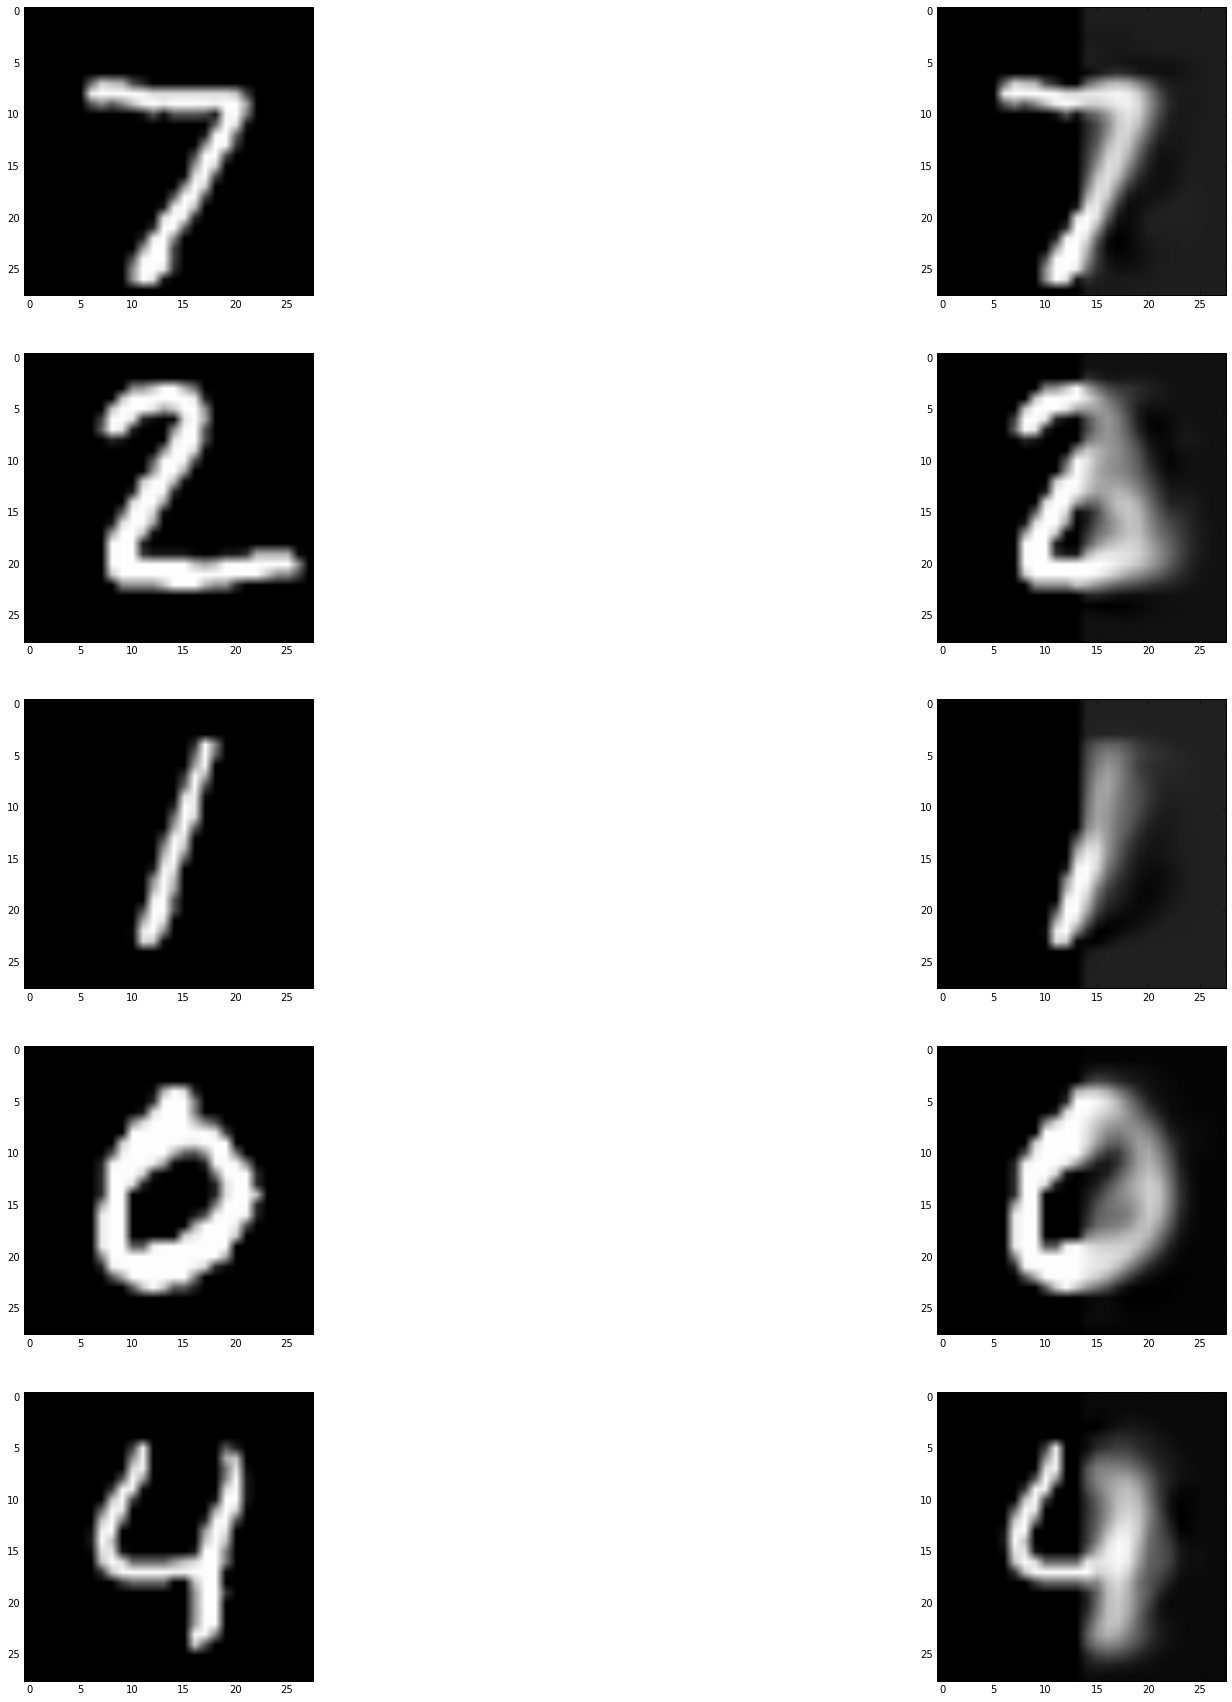

20.7610942996


In [71]:
with Timer("Ridge Regression"):
  rr = (SOAR(MNIST_RidgeRegression(), batch_size=740, alpha=10)
        .fit(mnist_training_l, mnist_training_r))
  rr.verbose = 20
  rrp = rr.predict(mnist_test_l)

rr_digits = mnist_join(mnist_test_l, rrp)
  
plot_many(MNIST_SHAPE, 2, mnist_test[:5], rr_digits[:5])
print MSE(rrp, mnist_test_r)

Iteration #0 d=57.7446135261


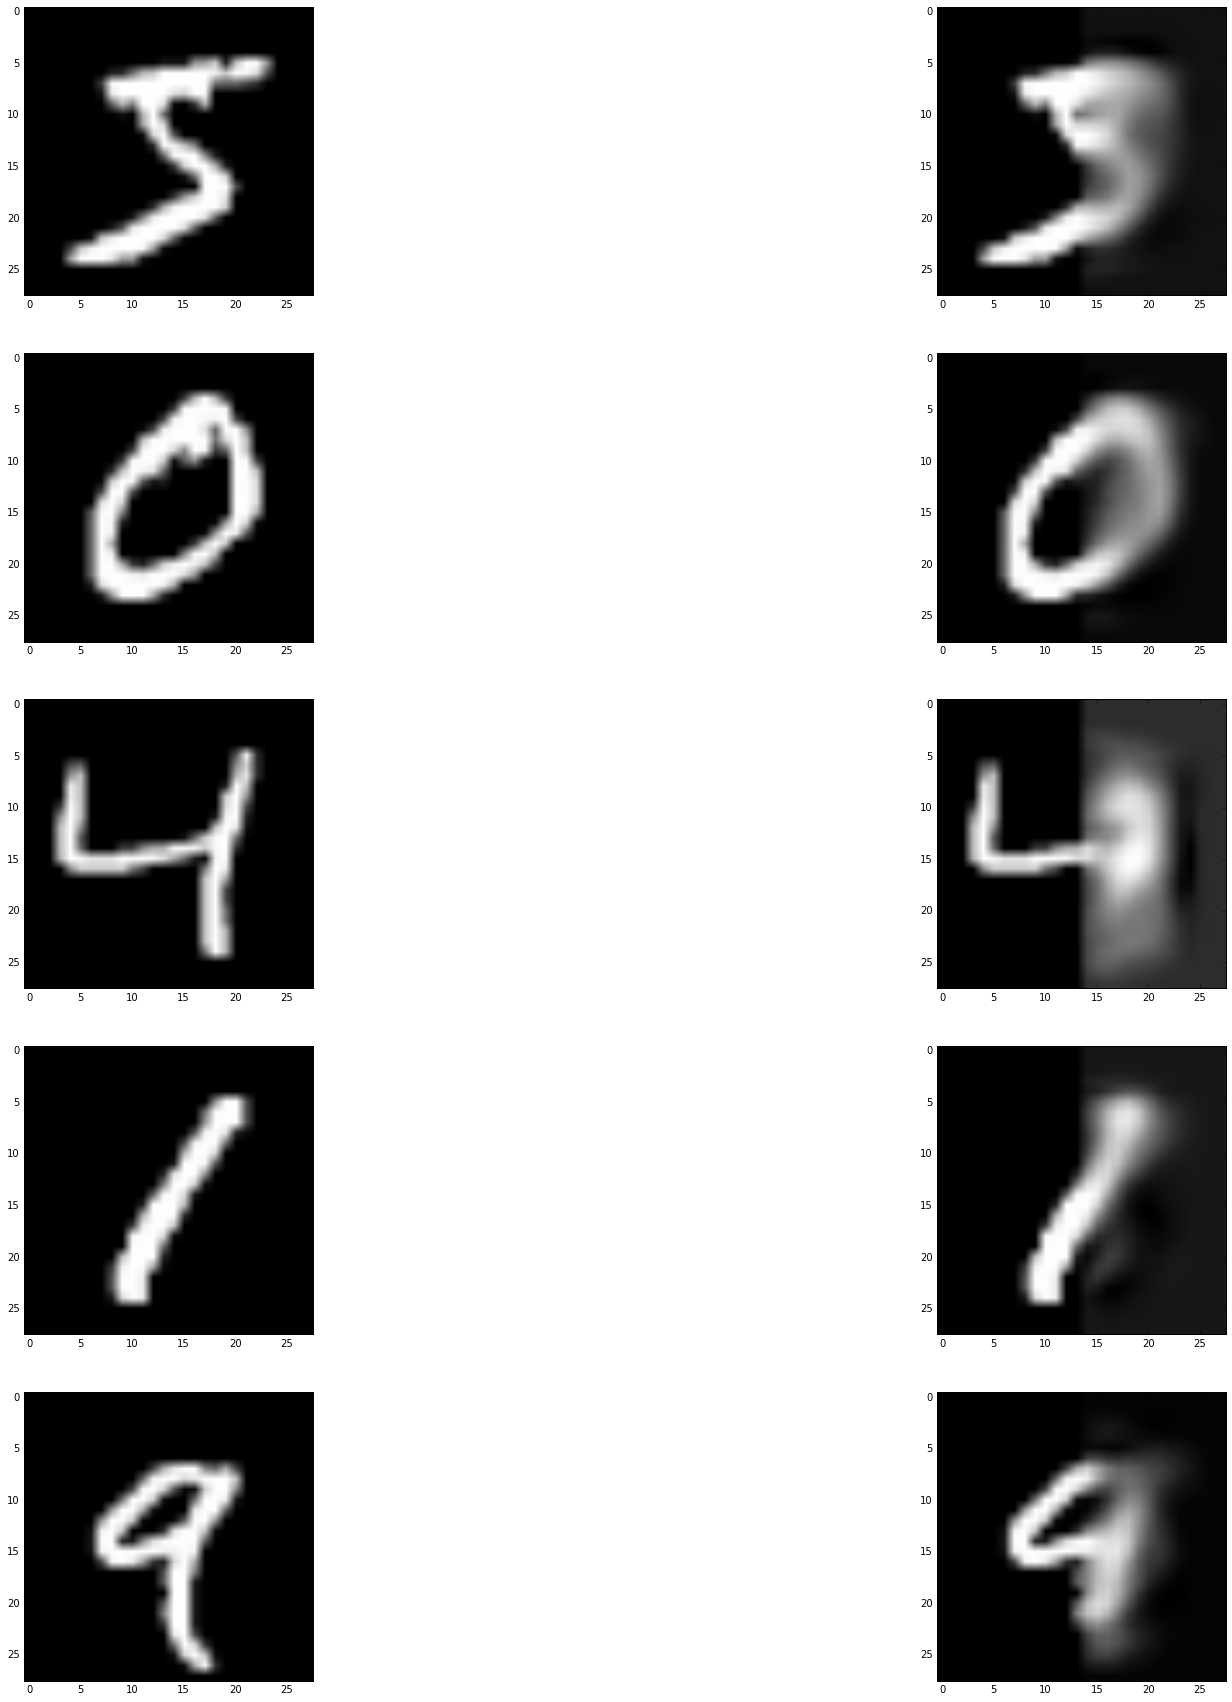

In [72]:
plot_many(MNIST_SHAPE, 2, mnist_training[:5], mnist_join(mnist_training_l[:5], rr.predict(mnist_training_l[:5])))